<a href="https://colab.research.google.com/github/TaliNatan/DSPS_TNatan/blob/main/HW6_TNatan/gaussian_process_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.datasets import elnino

!pip install george
import george
from george import kernels

## 0. Dataset

In [96]:
def load_elnino_dataset():
    """
    Downloads the El Niño dataset from the statsmodels package.

    Parameters
    ----------
    None

    Returns
    -------
    df : pd.DataFrame
        A Pandas dataframe containing the raw data of the El Niño dataset
        directly from the statsmodels package.
    """
    df = elnino.load_pandas().data
    return df

df = load_elnino_dataset()

In [97]:
def flatten_dataset(df):
    """
    Flatten the data in the dataframe.

    The sea surface temperature data is stored in a somewhat peculiar way in
    this dataset. The data has rows for every year between 1950 and 2010, and
    it has 12 columns for each month of each year.

    Re-order the data such that there is one 1-dim array for the temperature data.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns
    -------
    time : array-like
        A shape (732,) array containing every month from January 1950 to
        December 2010. You may encode the time as an integer
        (`time = [0, 1, 2, 3, ...]), as strings (`time = ['January 1950', ...])
        or however else you like.
    data : array-like
        A shape (732,) array containing the sea surface temperature for every
        month between January 1950 to December 2010.
    """
    rename_df = df.rename(columns={'JAN': 'a', 'FEB': 'b', 'MAR': 'c', 'APR': 'd', 'MAY': 'e', 
                                   'JUN': 'f', 'JUL': 'g', 'AUG': 'h', 'SEP': 'i', 'OCT': 'j',
                                   'NOV': 'k', 'DEC': 'l'})
    flatten_df = pd.melt(rename_df, id_vars=['YEAR'], value_vars=['a', 'b', 'c', 'd', 'e', 'f', 
                                                                  'g', 'h', 'i', 'j', 'k', 'l'])

    sorted_flatten_df = flatten_df.sort_values(['YEAR', 'variable'], ascending=[True, True])

    renamed_sorted_flatten_df = sorted_flatten_df.drop(['variable'], axis=1)

    # x, y = renamed_sorted_flatten_df["YEAR"].to_numpy(), renamed_sorted_flatten_df["value"].to_numpy()

    x, y = np.arange(1950, 2010+11/12, 1/12), renamed_sorted_flatten_df["value"].to_numpy()


    return x, y

    raise NotImplementedError()

x, y = flatten_dataset(df)

## 1. Vizualize

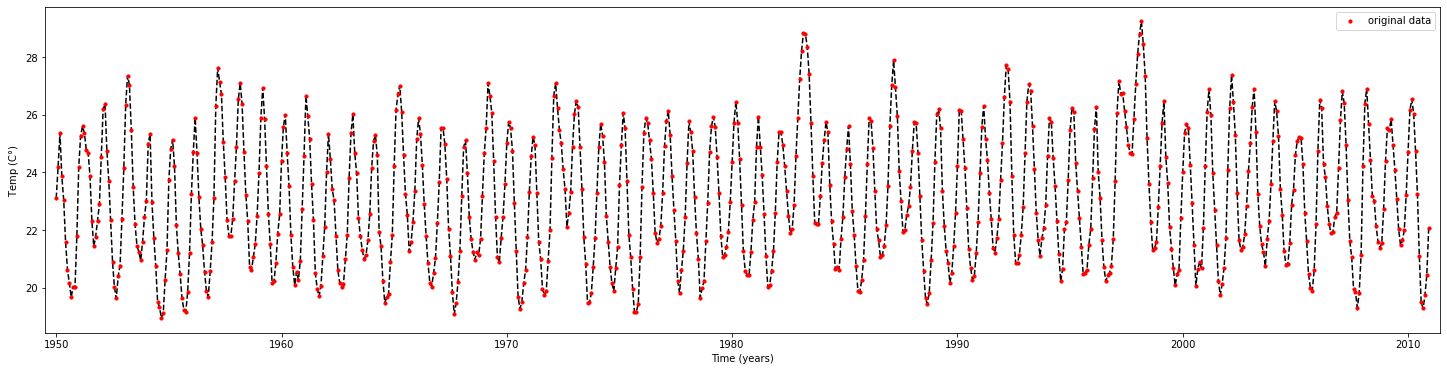

In [106]:
def visualize(df):
    """
    Visualize the El Niño – Sea Surface Temperature dataset.

    You decide the most appropriate way to visualize the dataset.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns
    -------
    fig :
    ax :
    """
    x, y = flatten_dataset(df)

    fig, ax = plt.subplots(1,1, figsize=(25,6))

    ax.plot(x,y, linestyle = '--', color = 'k')
    ax.scatter(x,y, s = 10, color = 'r',label = "original data", zorder = 10)
    ax.axis(xmin = x.min() - 1/2, xmax = x.max() + 1/2)
    ax.legend(loc = 'upper right')
    ax.set_xlabel("Time (years)")
    ax.set_ylabel(r"Temp (C$\degree$)")
    plt.show()
    
    return fig, ax

    raise NotImplementedError()

fig, ax = visualize(df)

The above plot shows the sea surface temperature (celcius) for every month from 1950 to 2010 in red. I have plotted the a line connecting the datapoints to better illistrate the periodicity of the temp values every year. The local minima and maxima of the periods vary every year but are vaguely cenetered around 24 degrees celcius.

## 2. Gaussian Process Regression (GPR)

In [99]:
def get_interpolated_time():
    """
    We are going to use GPR to interpolate the sea surface temperatures for
    every day between January 1st 1950 and December 1st 2030. There are 29,555
    days between those two dates (inclusive). Create and return an array of
    times for each day in that timeframe.

    Paramters
    ---------
    None

    Returns
    -------
    interp_time : array-like
        A shape (29555,) array, the times we want to interpolate. Encoded the
        same way you did before or any way you like.
    """
    return np.arange(0, 29555, 1)
    raise NotImplementedError()

t = get_interpolated_time()

In [100]:
def gaussian_process_regression(time, data, interp_time, initial_guess):
    """
    Using the george package, its documentation and startup guide, implement a
    gaussian process regressor on `time` and `data`. Then, use it to predict
    on `interp_time`.

    It will be helpful for you to write code to visualize the result of this
    initial model, but not necessary for the assignment.

    Parameters
    ----------
    time : array-like
        A shape (732,) array, times between 1950 and 2010, sampled every month.
    data : array-like
        A shape (732,) array, sea surface temperatures every month between 1950
        and 2010.
    interp_time : array-like
        A shape (29555,) array, times between 1950 and 2030, sampled every day.
    initial_guess : array-like or float
        The intial guess for the gaussian process that you make. The number of
        parameters will depend on the kernel you choose.

    Returns
    -------
    norm_t : array, normalized interpolated time (0 to 1), goes from 1950 to 2030
    norm_x : array, normalized time (0 to 0.75), goes from 1950 to 2010
    pred : array, predicted values
    pred_var : array, predicted values variance
    """

    x = time
    y = data
    t = interp_time
    
    norm_t = t/t.max()
    norm_x = ((x-x.min())/(x.max()-x.min())) * 0.75

    kernel = np.var(y) * kernels.ExpSquaredKernel(initial_guess)
    gp = george.GP(kernel)
    gp.compute(norm_x)

    pred, pred_var = gp.predict(y, norm_t, return_var=True)

    return norm_t, norm_x, pred, pred_var

    raise NotImplementedError()

initial_guess = 0.0001
norm_t, norm_x, pred, pred_var = gaussian_process_regression(x, y, t, initial_guess)

## 3. Optimize

In [101]:
def optimize(time, data, interp_time, initial_guess):
    """
    Using any optimization method you choose, find the optimal set of
    hyperparameters for your model.

    Print the results of your optimization.

    Parameters
    ----------
    time : array, original data time
    data : array, original data temps
    interp_time : array, values 0 - 29554
    initial_guess : int, initial guess for kernel

    Returns
    -------
    result.x : array, optimized hyperparameters for kernel
    pred : array, predicted temp values
    pred_var : array, predicted temp values variance
    """

    x = time
    y = data
    t = interp_time
    
    norm_t = t/t.max()
    norm_x = ((x-x.min())/(x.max()-x.min())) * 0.75
    
    kernel = np.var(y) * kernels.ExpSquaredKernel(initial_guess)
    gp = george.GP(kernel, mean = y.mean(), white_noise = 0, fit_mean = True, fit_white_noise = True)
    gp.compute(norm_x)
    
    pred, pred_var = gp.predict(y, norm_t, return_var=True)
    # print(gp.get_parameter_dict())
    
    from scipy.optimize import minimize
    
    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.log_likelihood(y)
    
    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(y)
    
    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
    
    gp.set_parameter_vector(result.x)
    # print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

    pred, pred_var = gp.predict(y, norm_t, return_var=True)

    print("the optimal set of hyperparameters is {}".format(result.x))

    return result.x, pred, pred_var
    
    raise NotImplementedError()

initial_guess = 0.000001
result, pred, pred_var = optimize(x, y, t, initial_guess)

the optimal set of hyperparameters is [ 23.08825963  -2.85648458   1.70643176 -11.92157316]


## 4. Visualize your model

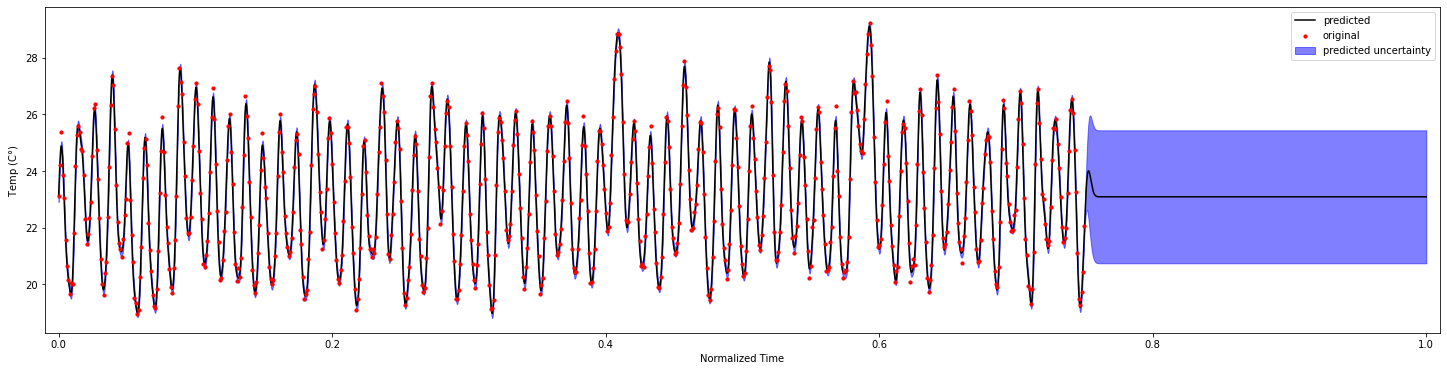

(<Figure size 1800x432 with 1 Axes>,
 <AxesSubplot:xlabel='Normalized Time', ylabel='Temp (C$\\degree$)'>)

In [104]:
def visualize_model(norm_x, norm_t, y, pred, pred_var):
    """
    Visualize your model. Use any method you like in visualizing your model but
    you must make at least one plot with a figure caption. Your
    visualization must also plot the uncertainties from the GP model.

    In your figure caption, comment on the effectiveness of your model in
    predicting temperatures beyond 2010.

    Parameters
    norm_x : array, normalized time (0 to 0.75), goes from 1950 to 2010
    norm_t : array, normalized interpolated time (0 to 1), goes from 1950 to 2030
    y : array, original temp data
    pred : array, predicted values
    pred_var : array, predicted values variance

    Returns
    -------
    fig :
    ax :

    """
    fig, ax = plt.subplots(1,1, figsize=(25,6))

    ax.scatter(norm_x, y, c = "r", s = 10, label = "original", zorder = 10)
    ax.plot(norm_t, pred, "k", label = "predicted")

    ax.fill_between(norm_t, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="b", alpha=0.5, label = "predicted uncertainty")

    ax.axis(xmin = -0.01, xmax = 1.01)

    ax.set_xlabel("Normalized Time")
    ax.set_ylabel(r"Temp (C$\degree$)")
    ax.legend(loc = "upper right")

    plt.show()

    return fig, ax
    
    raise NotImplementedError()

visualize_model(norm_x, norm_t, y, pred, pred_var)

The above plot shows the sea surface temperature (celcius) for every month from 1950 to 2010 in red, and the predicted data in black with uncertainty in blue. For each of gaussian regression, the data is shown over normalized time (0 is 1950, 1 is 2030). After 2010, we no longer have data from the El Niño dataset so our gaussian process attempts to predict 2010-2030 using a suared exponential kernal. After the original data ends, george predicts one last peak (smaller amplitude than all previous maxima) and then quickkly reverts to the mean of the 1950 to 2010 data. This kernel was unable to predict any of the periodicity seen in the original data despite capturing the original data well. The uncertainty of the gaussian process regression unsurprisingly blows up immediatly after the original data ends. By visual inspection, we can see that all the range of the previous periodicity is captured (more or less) within two sigma of the uncertainty so, while the later "prediction" does not find any periodicity, the uncertainty around this is large enough to capture the periodicity seen up to this point.